In [ ]:
%%capture
!pip install transformers
!pip install datasets

In [1]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import gc
import seaborn as sns
sns.set_theme()

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [117]:
batch_size = 8
train_limit_size = 20000

## Prepare SQuAD 2.0 dataset

The ***Stanford Question Answering Dataset*** (SQuAD) consists of questions (100,000)  on a set of Wikipedia articles where the answer to every question is a segment of text, or span, from the corresponding reading passage. In second version of SQuAD unanswerable questions were added (50,000) to look similar to answerable ones.  

The purpose of systems using the SQuAD2.0 dataset, must be not only answer questions when possible, but also determine when no answer is supported by the paragraph and abstain from answering.

In [ ]:
# %%capture
# !mkdir squad
# !wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json -O squad/train-v2.0.json
# !wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json -O squad/dev-v2.0.json

In [ ]:
from datasets import load_dataset

dataset = load_dataset("squad_v2")
# dataset = load_dataset("squad_v2", download_mode='force_redownload')

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 130319
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 11873
    })
})

In [ ]:
len(dataset["train"]), len(dataset["validation"])

(130319, 11873)

## Retrieve and Store the data

In [ ]:
from dataset_process import create_list_repres

dataset_train, dataset_validation = create_list_repres(dataset["train"], dataset["validation"])

In [ ]:
del dataset
gc.collect()

0

In [ ]:
# чтобы работало быстрее всё ограничим размер обучающей выборки
# потом увеличим

new_len_train = train_limit_size
new_len_validation = len(dataset_validation)
dataset_train = dataset_train[:new_len_train]
dataset_validation = dataset_validation[:new_len_validation]

In [ ]:
from dataset_process import unpack_answers

unpack_answers(dataset_train)
unpack_answers(dataset_validation)

In [ ]:
from dataset_process import add_end_index

add_end_index(dataset_train)
add_end_index(dataset_validation)

In [ ]:
print(dataset_train[8]["answers"])
print(dataset_train[7]["answers"])

{'text': 'decreases performance', 'answer_start': 1183, 'answer_end': 1204}
{'text': '', 'answer_start': -1, 'answer_end': -1}


## Create torch Dataset and Dataloader with token encoding

In [151]:
from transformers import AlbertTokenizerFast
from dataset_process import SquadDataset

In [146]:
from functools import partial
from dataset_process import collate_fn

tokenizer = AlbertTokenizerFast.from_pretrained('albert-base-v2')
collate_fn = partial(collate_fn, tokenizer)

In [149]:
ds_train = SquadDataset(tokenizer, dataset_train)
ds_val = SquadDataset(tokenizer, dataset_validation)

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/11873 [00:00<?, ?it/s]

In [150]:
dl_train = DataLoader(ds_train, batch_size=batch_size, collate_fn=collate_fn)
dl_val = DataLoader(ds_val, batch_size=batch_size, collate_fn=collate_fn)

## Build preprocessed embeddings

К контекстам необходимо добавить специальный токен вначале (например [CLF] -- дефолтный в бертах), для того чтобы можно было классифицировать отсутствие ответа на вопрос

In [64]:
from transformers import AlbertTokenizerFast, AlbertModel
tokenizer = AlbertTokenizerFast.from_pretrained('albert-base-v2')
model = AlbertModel.from_pretrained("albert-base-v2")
text = [dataset_train[0]["context"], dataset_train[2]["context"]]
encoded_input = tokenizer(text, return_tensors='pt', padding=True)
output = model(**encoded_input)

In [65]:
output[0].shape, output[1].shape

(torch.Size([2, 219, 768]), torch.Size([2, 768]))

In [ ]:
# def build_token_encodings(tokenizer, ds):
#     encoded_ds = []

#     for item in tqdm(ds, total=len(ds)):
#         encoded_context = tokenizer(item["context"], return_tensors='pt')
#         encoded_query = tokenizer(item["question"], return_tensors='pt')
#         new_item = {
#             'id': item["id"],
#             'context': encoded_context,
#             'question': encoded_query,
#         }
#         if item["answers"]["answer_end"] == -1:
#             new_item["answers"] = {'answer_start': 0, 'answer_end': 0}
#         else:
#             new_item["answers"] = {'answer_start': encoded_context.char_to_token(item["answers"]["answer_start"]),
#                                    'answer_end': encoded_context.char_to_token(item["answers"]["answer_end"])}
#         encoded_ds.append(new_item)
#     return encoded_ds

# encoded_train = build_token_encodings(tokenizer, dataset_train)
# encoded_validate = build_token_encodings(tokenizer, dataset_validation)

  0%|          | 0/20000 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (569 > 512). Running this sequence through the model will result in indexing errors


  0%|          | 0/11873 [00:00<?, ?it/s]

In [ ]:
# def build_embeddings(model, tokenizer, ds):
#     if torch.cuda.is_available():
#         model.to('cuda')
#     model.eval()
#     embeddings_ds = []

#     with torch.no_grad():

#         for item in tqdm(ds, total=len(ds)):
#             encoded_context = tokenizer(item["context"], return_tensors='pt')
#             if item["answers"]["answer_end"] == -1:
#                 tokens_answer = {'answer_start': 0, 'answer_end': 0}
#             else:
#                 tokens_answer = {'answer_start': encoded_context.char_to_token(item["answers"]["answer_start"]),
#                                     'answer_end': encoded_context.char_to_token(item["answers"]["answer_end"])}
#             embeddings_context = model(**encoded_context)
#             del encoded_context

#             encoded_query = tokenizer(item["question"], return_tensors='pt')
#             embeddings_query = model(**encoded_query)
#             del encoded_query

#             new_item = {
#                 'id': item['id'],
#                 'title': item['title'],
#                 'context': embeddings_context,
#                 'query': embeddings_query,
#                 'answers': tokens_answer
#             }
#             embeddings_ds.append(new_item)

#     return embeddings_ds

# encoded_train = build_embeddings(model, tokenizer, dataset_train)
# encoded_validate = build_embeddings(model, tokenizer, dataset_validation)

  0%|          | 0/20000 [00:00<?, ?it/s]

In [ ]:
# from transformers import AlbertTokenizer, AlbertModel, AlbertConfig

# model_name = "albert-base-v2"
# config = AlbertConfig.from_pretrained(model_name)
# tokenizer = AlbertTokenizer.from_pretrained(model_name, do_lower_case=True)
# model = AlbertModel.from_pretrained(model_name, config=config)

# def convert_sentence(list_sentence):
#     list_tokens = [tokenizer.encode(i) for i in list_sentence]
#     length_list = [len(i) for i in list_tokens]
#     max_length = max(length_list)

#     # pad the sequence
#     pad_id = tokenizer.pad_token_id
#     pad_tokens = [i + [pad_id] * (max_length - len(i)) for i in list_tokens]
#     atten_mask = [[1] * len(i) + [pad_id] * (max_length - len(i)) for i in list_tokens]
#     model.eval()
#     with torch.no_grad():
#         pad_tokens = torch.tensor(pad_tokens)
#         atten_mask = torch.tensor(atten_mask)
#         hiddens = model(input_ids=pad_tokens, attention_mask=atten_mask)[0]

#         # hiddens = hiddens.numpy().tolist()
#         # hiddens = [i[:length] for i, length in zip(hiddens, length_list)]
#     return hiddens, atten_mask, pad_tokens

# document = ["Hello this is Laobi", "This is laobi speaking", "Can you tell me what is your name? Hello, My name is Laobi!"]

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertModel: ['predictions.decoder.weight', 'predictions.LayerNorm.bias', 'predictions.decoder.bias', 'predictions.LayerNorm.weight', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# hiddens, atten_mask, pad_tokens = convert_sentence(document)

In [ ]:
# hiddens.shape

torch.Size([3, 19, 768])

## Baseline: ALBERT + default linear head

Для данной предобученной модели требуется немного другой датасет: текст должен состоять из контекста и вопроса, разделёнными разделяющим специальным символом. Поэтому чтобы запустить этот бейзлайн, необходимо создать отдельный датасет

* увеличить batch_size
* перевести модель в float16 вычисления
* перенести модель на gpu
* мб можно уменьшить hidden_size модели

In [156]:
from models import load_albertQA
model = load_albertQA().to(device)

config.json:   0%|          | 0.00/716 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/46.7M [00:00<?, ?B/s]

Some weights of the model checkpoint at twmkn9/albert-base-v2-squad2 were not used when initializing AlbertForQuestionAnswering: ['albert.pooler.weight', 'albert.pooler.bias']
- This IS expected if you are initializing AlbertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [162]:
tmp = model(**next(iter(dl_train))["context"])

In [185]:
print(tmp.start_logits[0].detach().numpy()[1:].argmax())
tmp.end_logits[0].detach().numpy()[1:].argmax()

214


217

<Axes: >

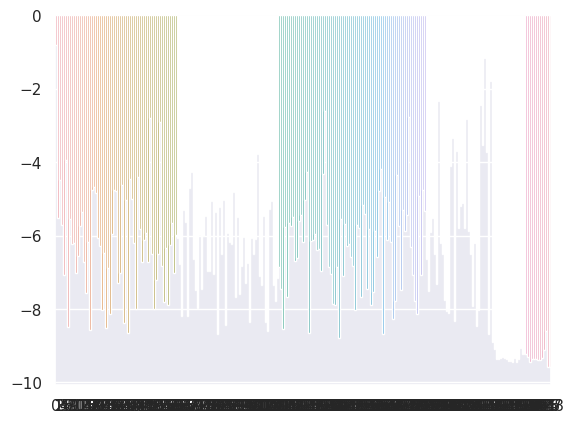

In [174]:
sns.barplot(x = list(range(len(tmp[0][0].detach().numpy()))), y=tmp[0][0].detach().numpy())

## Custom model implementation

In [16]:
from models import AlbertSquad

model = AlbertSquad(hidden_size=128, nhead=16)